<h1>ASL Alphabet Detection

<h2>1. Collect Data

In [14]:
import os
import cv2

DATA_DIR = './data_alphabet'
if not os.path.exists(DATA_DIR):
    os.makedirs(DATA_DIR)
# classes = ['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y']
#            ,'0','1','2','3','4','5','6','7','8','9']
# classes = ['A','B','C','D','E','F','G','H','I','J','K','L','M','N']
classes = ['Y']
dataset_size = 100

cap = cv2.VideoCapture(0)
for j in classes:
    if not os.path.exists(os.path.join(DATA_DIR, j)):
        os.makedirs(os.path.join(DATA_DIR, j))

    print(f'Collecting data for class {j}')
    
    # Find the highest number in existing filenames to continue from there
    existing_files = os.listdir(os.path.join(DATA_DIR, j))
    existing_numbers = []
    for filename in existing_files:
        try:
            # Extract the number from filenames like "123.jpg"
            num = int(os.path.splitext(filename)[0])
            existing_numbers.append(num)
        except ValueError:
            continue
    
    # If there are existing files, start counting after the highest number
    # Otherwise start from 0
    starting_counter = max(existing_numbers) + 1 if existing_numbers else 0
    print(f"Starting from counter value: {starting_counter} (found {len(existing_numbers)} existing images)")

    done = False
    while True:
        ret, frame = cap.read()
        cv2.putText(frame, 'Ready? Press "Q" ! :)', (100, 50), cv2.FONT_HERSHEY_SIMPLEX, 1.3, (0, 255, 0), 3,
                    cv2.LINE_AA)
        cv2.imshow('frame', frame)
        if cv2.waitKey(25) == ord('q'):
            break

    counter = starting_counter
    target_count = starting_counter + dataset_size
    
    while counter < target_count:
        ret, frame = cap.read()
        cv2.putText(frame, f'Collecting: {counter-starting_counter+1}/{dataset_size}', (50, 50), 
                   cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
        cv2.imshow('frame', frame)
        cv2.waitKey(25)
        cv2.imwrite(os.path.join(DATA_DIR, str(j), '{}.jpg'.format(counter)), frame)

        counter += 1
    
    print(f"Collected {dataset_size} new images for class {j}. Total: {target_count}")

cap.release()
cv2.destroyAllWindows()

Starting from counter value: 200 (found 200 existing images)
Collected 100 new images for class Y. Total: 300


<h3>2. Create Dataset for Training

In [15]:
import os
import mediapipe as mp
import cv2
import pickle
import numpy as np

mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles

hands = mp_hands.Hands(static_image_mode=True, min_detection_confidence=0.3)

datas = []
labels = []

# Only process these directories
detection_failures = 0
total_images = 0
DATA_DIR = './data_alphabet'
classes = ['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y']
for dir_ in os.listdir(DATA_DIR):
    # Skip hidden files and non-class directories
    if dir_.startswith('.') or dir_ not in classes:
        print(f"Skipping directory: {dir_}")
        continue

    print(f"Processing class: {dir_}")
    class_path = os.path.join(DATA_DIR, dir_)

    # Skip if not a directory
    if not os.path.isdir(class_path):
        continue

    # Process images in this class directory
    class_images = 0
    class_successes = 0

    for img_path in os.listdir(class_path):
        if not (img_path.endswith('.jpg') or img_path.endswith('.png')):
            continue

        total_images += 1
        class_images += 1

        try:
            # Read and process image
            img = cv2.imread(os.path.join(class_path, img_path))
            if img is None:
                print(f"Failed to read image: {img_path}")
                continue

            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            # Process with MediaPipe
            results = hands.process(img_rgb)

            if not results.multi_hand_landmarks:
                detection_failures += 1
                continue

            # Get the first detected hand
            hand_landmarks = results.multi_hand_landmarks[0]

            # Extract and normalize coordinates
            x_coords = [landmark.x for landmark in hand_landmarks.landmark]
            y_coords = [landmark.y for landmark in hand_landmarks.landmark]

            # Normalize relative to hand bounding box
            x_min, x_max = min(x_coords), max(x_coords)
            y_min, y_max = min(y_coords), max(y_coords)

            # Create feature vector
            data_aux = []
            for i in range(len(hand_landmarks.landmark)):
                # Normalize to [0,1] range within hand bounding box
                norm_x = (hand_landmarks.landmark[i].x - x_min) / (x_max - x_min) if x_max > x_min else 0
                norm_y = (hand_landmarks.landmark[i].y - y_min) / (y_max - y_min) if y_max > y_min else 0

                data_aux.append(norm_x)
                data_aux.append(norm_y)

            # Verify we have the expected number of features
            if len(data_aux) != 42:  # 21 landmarks × 2 coordinates
                print(f"Unexpected feature count in {img_path}: {len(data_aux)}")
                continue

            datas.append(data_aux)
            labels.append(dir_)
            class_successes += 1

        except Exception as e:
            print(f"Error processing {img_path}: {e}")

    print(f"Class {dir_}: Processed {class_successes}/{class_images} images successfully")

print(f"Total: Processed {len(datas)}/{total_images} images successfully")
print(f"Hand detection failures: {detection_failures}")

# Check class balance
unique, counts = np.unique(labels, return_counts=True)
class_distribution = dict(zip(unique, counts))
print("Class distribution:", class_distribution)

data_array = np.array(datas)
label_array = np.array(labels)

# Create a random permutation of indices
indices = np.random.permutation(len(data_array))

# Shuffle both data and labels using the same permutation
shuffled_data = data_array[indices]
shuffled_labels = label_array[indices]

# Save the shuffled dataset
f = open('train_data_set/data_alphabet_both.pickle', 'wb')
pickle.dump({'data': shuffled_data.tolist(), 'labels': shuffled_labels.tolist()}, f)
f.close()
print("Shuffled dataset saved to data.pickle")

Skipping directory: .DS_Store
Processing class: R
Class R: Processed 300/300 images successfully
Processing class: U
Class U: Processed 270/300 images successfully
Processing class: I
Class I: Processed 300/300 images successfully
Processing class: N
Class N: Processed 300/300 images successfully
Processing class: G
Class G: Processed 300/300 images successfully
Processing class: T
Class T: Processed 300/300 images successfully
Processing class: S
Class S: Processed 300/300 images successfully
Processing class: A
Class A: Processed 300/300 images successfully
Processing class: F
Class F: Processed 300/300 images successfully
Processing class: O
Class O: Processed 300/300 images successfully
Processing class: H
Class H: Processed 296/300 images successfully
Processing class: M
Class M: Processed 299/300 images successfully
Processing class: J
Class J: Processed 300/300 images successfully
Processing class: C
Class C: Processed 296/300 images successfully
Processing class: D
Class D: Pro

<h3>3. Train CNN

In [6]:
import torch
torch.backends.mps.is_available()
torch.mps.device_count()

1

In [16]:
device = 'mps' if torch.backends.mps.is_available() else 'cpu' # adjust 'mps' for mac or 'gpu' for cuda
device

'mps'

Min length: 42
Max length: 42
Unique lengths: {42}
Epoch 1/50: Train Loss: 2.5068, Train Acc: 0.2125, Val Loss: 1.1648, Val Acc: 0.5688
Epoch 2/50: Train Loss: 1.1638, Train Acc: 0.5522, Val Loss: 0.6575, Val Acc: 0.7703
Epoch 3/50: Train Loss: 0.8942, Train Acc: 0.6619, Val Loss: 0.4606, Val Acc: 0.8522
Epoch 4/50: Train Loss: 0.7306, Train Acc: 0.7200, Val Loss: 0.4229, Val Acc: 0.8388
Epoch 5/50: Train Loss: 0.6261, Train Acc: 0.7638, Val Loss: 0.3171, Val Acc: 0.8899
Epoch 6/50: Train Loss: 0.5712, Train Acc: 0.7880, Val Loss: 0.2637, Val Acc: 0.9281
Epoch 7/50: Train Loss: 0.4606, Train Acc: 0.8389, Val Loss: 0.2281, Val Acc: 0.9161
Epoch 8/50: Train Loss: 0.4568, Train Acc: 0.8350, Val Loss: 0.1805, Val Acc: 0.9584
Epoch 9/50: Train Loss: 0.3967, Train Acc: 0.8597, Val Loss: 0.1627, Val Acc: 0.9537
Epoch 10/50: Train Loss: 0.3492, Train Acc: 0.8762, Val Loss: 0.1352, Val Acc: 0.9624
Epoch 11/50: Train Loss: 0.3324, Train Acc: 0.8824, Val Loss: 0.1184, Val Acc: 0.9718
Epoch 12/50:

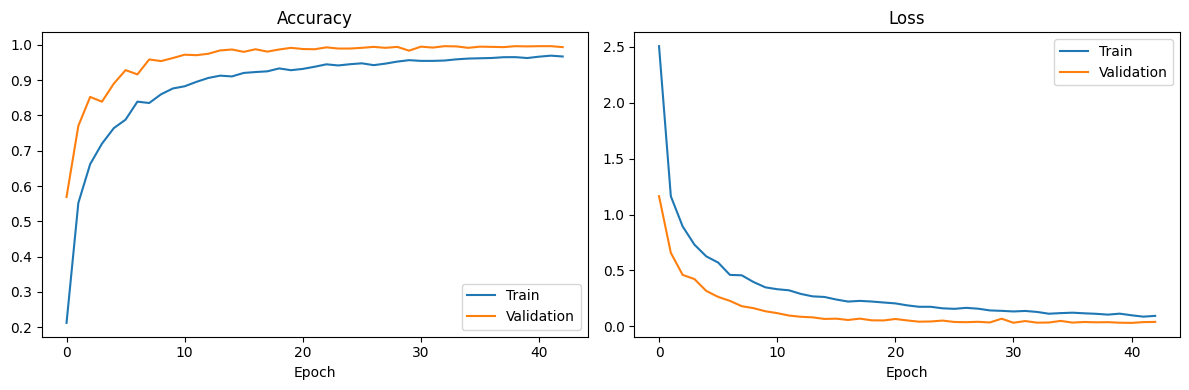

Model and label mapping saved


In [17]:
import pickle
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

#Using GPU to train faster
device = 'mps' if torch.backends.mps.is_available() else 'cpu'

# Load data from pickle file
data_dict = pickle.load(open('./train_data_set/data_alphabet_both.pickle', 'rb'))

# Extract data and labels
data = data_dict['data']
labels = np.asarray(data_dict['labels'])

# Check for consistency in data lengths
lengths = [len(x) for x in data]
print("Min length:", min(lengths))
print("Max length:", max(lengths))
print("Unique lengths:", set(lengths))

# Convert data to numpy array with padding if needed
if len(set(lengths)) == 1:
    # All elements have the same length
    data_array = np.array(data, dtype=float)
else:
    # Elements have different lengths, need padding
    max_len = max(lengths)
    data_array = np.zeros((len(data), max_len), dtype=float)
    for i, item in enumerate(data):
        data_array[i, :len(item)] = item

# Convert labels to numeric
label_map = {label: i for i, label in enumerate(np.unique(labels))}
numeric_labels = np.array([label_map[label] for label in labels])
reverse_label_map = {i: label for label, i in label_map.items()}

# Split data
x_train, x_test, y_train, y_test = train_test_split(
    data_array, numeric_labels, test_size=0.2, shuffle=True, stratify=numeric_labels
)

# Reshape data for CNN (samples, channels, timesteps, features)
# For hand landmarks, we reshape 42 values into 1 channel, 21 timesteps with 2 features (x,y)
x_train = x_train.reshape(x_train.shape[0], 1, 21, 2)
x_test = x_test.reshape(x_test.shape[0], 1, 21, 2)

# Convert to PyTorch tensors
x_train_tensor = torch.FloatTensor(x_train)
y_train_tensor = torch.LongTensor(y_train)
x_test_tensor = torch.FloatTensor(x_test)
y_test_tensor = torch.LongTensor(y_test)

# Create datasets and dataloaders
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define CNN model
class HandGestureCNN(nn.Module):
    def __init__(self, num_classes):
        super(HandGestureCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=(3, 2), padding=(1, 0))
        self.pool1 = nn.MaxPool2d(kernel_size=(2, 1))
        self.conv2 = nn.Conv2d(64, 128, kernel_size=(3, 1), padding=(1, 0))
        self.pool2 = nn.MaxPool2d(kernel_size=(2, 1))

        # Calculate size after convolutions and pooling
        self.fc_input_size = 128 * 5 * 1

        self.fc1 = nn.Linear(self.fc_input_size, 128)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, num_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor: 
        x = torch.relu(self.conv1(x))
        x = self.pool1(x)
        x = torch.relu(self.conv2(x))
        x = self.pool2(x)

        x = x.view(-1, self.fc_input_size)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize model, loss function, and optimizer
model = HandGestureCNN(num_classes=len(label_map)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training function
def train(model, train_loader, criterion, optimizer, device='cpu'):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = correct / total
    return train_loss, train_acc

# Evaluation function
def evaluate(model, test_loader, criterion, device='cpu'):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.inference_mode():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, targets)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    test_loss = running_loss / len(test_loader)
    test_acc = correct / total
    return test_loss, test_acc

# Training loop
epochs = 50
train_losses = []
train_accs = []
val_losses = []
val_accs = []
best_val_acc = 0.0
patience = 10
counter = 0

for epoch in range(epochs):
    train_loss, train_acc = train(model, train_loader, criterion, optimizer,device)
    val_loss, val_acc = evaluate(model, test_loader, criterion,device)

    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f'Epoch {epoch+1}/{epochs}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

    # Early stopping
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        counter = 0
        # Save best model - move to CPU first
        torch.save(model.to('cpu').state_dict(), 'models/best_cnn_model_alphabet_both.pth')
        model = model.to(device)  # Move back to MPS
    else:
        counter += 1
        if counter >= patience:
            print(f'Early stopping at epoch {epoch+1}')
            break

model = model.to('cpu')
model.load_state_dict(torch.load('models/best_cnn_model_alphabet_both.pth'))

# Final evaluation on CPU
_, test_acc = evaluate(model, test_loader, criterion, device='cpu')
print(f'Final test accuracy: {test_acc:.4f}')

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_accs, label='Train')
plt.plot(val_accs, label='Validation')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.title('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.savefig('training_history.png')
plt.show()

# Save the label mapping for inference
with open('models/label_map_alphabet_both.pickle', 'wb') as f:
    pickle.dump({'label_map_alphabet': label_map, 'reverse_label_map_alphabet': reverse_label_map}, f)
print("Model and label mapping saved")

<h3>4. Live Test 

In [19]:
import pickle
import cv2
import mediapipe as mp
import numpy as np
import torch
import torch.nn as nn

# Define CNN model class (must match your training architecture)
class HandGestureCNN(nn.Module):
    def __init__(self, num_classes):
        super(HandGestureCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=(3, 2), padding=(1, 0))
        self.pool1 = nn.MaxPool2d(kernel_size=(2, 1))
        self.conv2 = nn.Conv2d(64, 128, kernel_size=(3, 1), padding=(1, 0))
        self.pool2 = nn.MaxPool2d(kernel_size=(2, 1))

        # Calculate size after convolutions and pooling
        self.fc_input_size = 128 * 5 * 1

        self.fc1 = nn.Linear(self.fc_input_size, 128)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.pool1(x)
        x = torch.relu(self.conv2(x))
        x = self.pool2(x)

        x = x.view(-1, self.fc_input_size)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Load label mapping
with open('models/label_map_alphabet_both.pickle', 'rb') as f:
    label_info = pickle.load(f)
    label_map = label_info['label_map_alphabet']
    reverse_label_map = label_info['reverse_label_map_alphabet']

# Load model
num_classes = len(label_map)
model = HandGestureCNN(num_classes)
model.load_state_dict(torch.load('models/best_cnn_model_alphabet_both.pth'))
model.eval()  # Set to evaluation mode

# Initialize video capture
cap = cv2.VideoCapture(0)

# Initialize MediaPipe
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles

# Use non-static mode for video
hands = mp_hands.Hands(static_image_mode=False, min_detection_confidence=0.5, min_tracking_confidence=0.5, max_num_hands=1)

while True:
    # Read frame
    ret, frame = cap.read()
    if not ret:
        break

    H, W, _ = frame.shape

    # Convert to RGB for MediaPipe
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Process with MediaPipe
    results = hands.process(frame_rgb)

    if results.multi_hand_landmarks:
        # Get the first detected hand
        hand_landmarks = results.multi_hand_landmarks[0]

        # Draw hand landmarks
        mp_drawing.draw_landmarks(
            frame,
            hand_landmarks,
            mp_hands.HAND_CONNECTIONS,
            mp_drawing_styles.get_default_hand_landmarks_style(),
            mp_drawing_styles.get_default_hand_connections_style())

        # Extract coordinates
        x_coords = [landmark.x for landmark in hand_landmarks.landmark]
        y_coords = [landmark.y for landmark in hand_landmarks.landmark]

        # Normalize coordinates
        x_min, x_max = min(x_coords), max(x_coords)
        y_min, y_max = min(y_coords), max(y_coords)

        # Create feature vector
        data_aux = []
        for i in range(len(hand_landmarks.landmark)):
            # Normalize to [0,1] range within hand bounding box
            norm_x = (hand_landmarks.landmark[i].x - x_min) / (x_max - x_min) if x_max > x_min else 0
            norm_y = (hand_landmarks.landmark[i].y - y_min) / (y_max - y_min) if y_max > y_min else 0

            data_aux.append(norm_x)
            data_aux.append(norm_y)

        try:
            # Prepare input for CNN
            input_tensor = np.array(data_aux).reshape(1, 1, 21, 2)
            input_tensor = torch.FloatTensor(input_tensor)

            # Make prediction
            with torch.no_grad():
                outputs = model(input_tensor)
                probabilities = torch.nn.functional.softmax(outputs, dim=1)
                confidence, predicted = torch.max(probabilities, 1)

                # Convert to numpy for display
                predicted_class = predicted.item()
                confidence_value = confidence.item()

                # Get class name
                prediction = reverse_label_map[predicted_class]

                # Calculate bounding box coordinates
                x1 = max(0, int(x_min * W) - 10)
                y1 = max(0, int(y_min * H) - 10)
                x2 = min(W, int(x_max * W) + 10)
                y2 = min(H, int(y_max * H) + 10)
                
                # Draw bounding box
                cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
                
                # Prepare text with confidence
                text = f"{prediction} ({confidence_value:.2f})"
                
                # Get text size for better positioning
                text_size = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, 1, 2)[0]
                
                # Position text above the bounding box
                text_x = x1
                text_y = y1 - 10 if y1 - 10 > text_size[1] else y1 + text_size[1] + 10
                
                # Draw text background
                cv2.rectangle(frame, 
                             (text_x, text_y - text_size[1] - 5),
                             (text_x + text_size[0], text_y + 5),
                             (0, 255, 0), -1)
                
                # Draw text
                cv2.putText(frame, text, (text_x, text_y), 
                           cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), 2, cv2.LINE_AA)
                
        except Exception as e:
            print(f"Prediction error: {e}")

    # Display frame
    cv2.imshow('Hand Gesture Recognition (CNN)', frame)

    # Exit on 'q' press
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release resources
cap.release()
cv2.destroyAllWindows()

<h3>4. Upload Video Test

In [ ]:
import pickle
import cv2
import mediapipe as mp
import numpy as np
import torch
import torch.nn as nn
import os
import argparse
from tqdm import tqdm
import json
import time
from pathlib import Path

# Define CNN model class (must match your training architecture)
class HandGestureCNN(nn.Module):
    def __init__(self, num_classes):
        super(HandGestureCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=(3, 2), padding=(1, 0))
        self.pool1 = nn.MaxPool2d(kernel_size=(2, 1))
        self.conv2 = nn.Conv2d(64, 128, kernel_size=(3, 1), padding=(1, 0))
        self.pool2 = nn.MaxPool2d(kernel_size=(2, 1))

        # Calculate size after convolutions and pooling
        self.fc_input_size = 128 * 5 * 1

        self.fc1 = nn.Linear(self.fc_input_size, 128)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.pool1(x)
        x = torch.relu(self.conv2(x))
        x = self.pool2(x)

        x = x.view(-1, self.fc_input_size)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

def process_video(video_path, output_path=None):
    # Load label mapping
    with open('models/label_map_alphabet_both.pickle', 'rb') as f:
        label_info = pickle.load(f)
        label_map = label_info['label_map_alphabet']
        reverse_label_map = label_info['reverse_label_map_alphabet']

    # Load model
    num_classes = len(label_map)
    model = HandGestureCNN(num_classes)
    model.load_state_dict(torch.load('models/best_cnn_model_alphabet_both.pth'))
    model.eval()  # Set to evaluation mode

    # Initialize video capture from file
    cap = cv2.VideoCapture(video_path)
    
    # Check if video opened successfully
    if not cap.isOpened():
        print(f"Error: Could not open video {video_path}")
        return {
            "processed_video": video_path,
            "output_video": None,
            "status": "error",
            "error_message": "Could not open video file",
            "detected_word": "",
            "frame_by_frame": []
        }
    
    # Get video properties
    fps = cap.get(cv2.CAP_PROP_FPS)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    # Initialize MediaPipe
    mp_hands = mp.solutions.hands
    mp_drawing = mp.solutions.drawing_utils
    mp_drawing_styles = mp.solutions.drawing_styles

    # Use non-static mode for video
    hands = mp_hands.Hands(static_image_mode=False, min_detection_confidence=0.5, min_tracking_confidence=0.5, max_num_hands=1)

    # Set up video writer if output path is specified
    out = None
    if output_path:
        os.makedirs(os.path.dirname(output_path), exist_ok=True)
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # You can change the codec as needed
        out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))
    
    # Variables for detecting stable letter periods
    frame_results = []
    letter_history = []
    current_letter = None
    letter_stable_count = 0
    stable_threshold = max(int(fps * 0.4), 4)  # Require letter to be stable for 0.5 seconds or at least 5 frames
    min_confidence = 0.7  # Minimum confidence to consider a prediction
    
    # Add text overlay with instructions
    instruction_text = "Please hold each sign for at least 0.5 seconds"
    
    # Process each frame with progress bar
    pbar = tqdm(total=total_frames, desc=f"Processing {os.path.basename(video_path)}")
    
    # Store detailed letter detections with timestamps
    letter_detections = []
    
    # Counter for frames without any hand detection
    no_hand_count = 0
    pause_threshold = max(int(fps * 1.0), 10)  # 1 second of no hands means a word break
    
    while True:
        # Read frame
        ret, frame = cap.read()
        if not ret:
            break

        H, W, _ = frame.shape
        frame_number = int(cap.get(cv2.CAP_PROP_POS_FRAMES))
        frame_time = frame_number / fps  # Time in seconds

        # Convert to RGB for MediaPipe
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # Process with MediaPipe
        results = hands.process(frame_rgb)
        
        current_prediction = None
        current_confidence = 0
        
        # Add instruction text to the frame
        cv2.putText(frame, instruction_text, (10, H - 20), 
                  cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2, cv2.LINE_AA)
        
        if results.multi_hand_landmarks:
            no_hand_count = 0  # Reset counter when hand is detected
            
            # Get the first detected hand
            hand_landmarks = results.multi_hand_landmarks[0]

            # Draw hand landmarks
            mp_drawing.draw_landmarks(
                frame,
                hand_landmarks,
                mp_hands.HAND_CONNECTIONS,
                mp_drawing_styles.get_default_hand_landmarks_style(),
                mp_drawing_styles.get_default_hand_connections_style())

            # Extract coordinates
            x_coords = [landmark.x for landmark in hand_landmarks.landmark]
            y_coords = [landmark.y for landmark in hand_landmarks.landmark]

            # Normalize coordinates
            x_min, x_max = min(x_coords), max(x_coords)
            y_min, y_max = min(y_coords), max(y_coords)

            # Create feature vector
            data_aux = []
            for i in range(len(hand_landmarks.landmark)):
                # Normalize to [0,1] range within hand bounding box
                norm_x = (hand_landmarks.landmark[i].x - x_min) / (x_max - x_min) if x_max > x_min else 0
                norm_y = (hand_landmarks.landmark[i].y - y_min) / (y_max - y_min) if y_max > y_min else 0

                data_aux.append(norm_x)
                data_aux.append(norm_y)

            try:
                # Prepare input for CNN
                input_tensor = np.array(data_aux).reshape(1, 1, 21, 2)
                input_tensor = torch.FloatTensor(input_tensor)

                # Make prediction
                with torch.no_grad():
                    outputs = model(input_tensor)
                    probabilities = torch.nn.functional.softmax(outputs, dim=1)
                    confidence, predicted = torch.max(probabilities, 1)

                    # Convert to numpy for display
                    predicted_class = predicted.item()
                    confidence_value = confidence.item()

                    # Get class name
                    prediction = reverse_label_map[predicted_class]
                    current_prediction = prediction
                    current_confidence = confidence_value

                    # Update letter history for stability tracking
                    if confidence_value >= min_confidence:
                        letter_history.append((prediction, confidence_value))
                        # Keep history to a reasonable size
                        if len(letter_history) > stable_threshold * 2:
                            letter_history = letter_history[-stable_threshold * 2:]
                    
                    # Calculate bounding box coordinates
                    x1 = max(0, int(x_min * W) - 10)
                    y1 = max(0, int(y_min * H) - 10)
                    x2 = min(W, int(x_max * W) + 10)
                    y2 = min(H, int(y_max * H) + 10)
                    
                    # Draw bounding box
                    cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
                    
                    # Prepare text with confidence
                    text = f"{prediction} ({confidence_value:.2f})"
                    
                    # Get text size for better positioning
                    text_size = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, 1, 2)[0]
                    
                    # Position text above the bounding box
                    text_x = x1
                    text_y = y1 - 10 if y1 - 10 > text_size[1] else y1 + text_size[1] + 10
                    
                    # Draw text background
                    cv2.rectangle(frame, 
                                (text_x, text_y - text_size[1] - 5),
                                (text_x + text_size[0], text_y + 5),
                                (0, 255, 0), -1)
                    
                    # Draw text
                    cv2.putText(frame, text, (text_x, text_y), 
                              cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), 2, cv2.LINE_AA)
                
            except Exception as e:
                print(f"Prediction error: {e}")
        else:
            # No hand detected
            no_hand_count += 1
            letter_history = []  # Clear history when no hand is detected
        
        # Stability analysis
        if len(letter_history) >= stable_threshold:
            # Check if the last N predictions are the same
            recent_letters = [item[0] for item in letter_history[-stable_threshold:]]
            most_common = max(set(recent_letters), key=recent_letters.count)
            
            # If we have a consistent prediction
            if recent_letters.count(most_common) >= stable_threshold * 0.8:  # 80% agreement
                # If this is a new stable letter (different from current)
                if most_common != current_letter:
                    if current_letter is not None:
                        # Record the previously stable letter
                        letter_detections.append({
                            "letter": current_letter,
                            "confidence": letter_history[-1][1],
                            "time": frame_time,
                            "frame": frame_number
                        })
                    
                    # Set new current letter
                    current_letter = most_common
                    letter_stable_count = 1
                else:
                    # Still the same letter, just update count
                    letter_stable_count += 1
        
        # Check for word break (pause in signing)
        if no_hand_count >= pause_threshold and current_letter is not None:
            # Add a space to indicate word break
            letter_detections.append({
                "letter": " ",
                "confidence": 1.0,
                "time": frame_time,
                "frame": frame_number,
                "is_word_break": True
            })
            current_letter = None
            letter_stable_count = 0
        
        # Add frame counter and current letter status
        text_status = f"Frame: {frame_number}/{total_frames}"
        if current_letter:
            text_status += f" | Current: {current_letter} ({letter_stable_count})"
            
        cv2.putText(frame, text_status, (10, 30), 
                  cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2, cv2.LINE_AA)
        
        # Save frame result for detailed analysis
        frame_results.append((frame_number, current_prediction, current_confidence))
        
        # Write the frame to output video if specified
        if out:
            out.write(frame)
            
        # Update progress bar
        pbar.update(1)

    # Close progress bar
    pbar.close()
    
    # Release resources
    cap.release()
    if out:
        out.release()
    
    # Process letter detections to create a clean sentence
    # First, filter out low confidence or sporadic detections
    filtered_detections = []
    prev_letter = None
    for detection in letter_detections:
        letter = detection["letter"]
        print(letter)
        # Skip if it's the same as previous (avoid repetition)
        if letter == prev_letter and letter != " ":
            continue
            
        # Add to filtered list
        filtered_detections.append(detection)
        prev_letter = letter
    
    # Create the detected word/sentence
    detected_sentence = ''.join([d["letter"] for d in filtered_detections])
    
    # Generate summary
    summary = {
        "processed_video": video_path,
        "output_video": output_path,
        "status": "success",
        "detected_sentence": detected_sentence,
        "letter_detections": [
            {
                "letter": d["letter"],
                "confidence": round(float(d["confidence"]), 2),
                "time_seconds": round(d["time"], 2),
                "frame": d["frame"],
                "is_word_break": d.get("is_word_break", False)
            }
            for d in filtered_detections
        ]
    }
    
    return summary

def process_folder(input_folder, output_video_folder, output_text_folder):
    # Create output folders if they don't exist
    os.makedirs(output_video_folder, exist_ok=True)
    os.makedirs(output_text_folder, exist_ok=True)
    
    # Get all video files in input folder
    video_extensions = ['.mp4', '.avi', '.mkv', '.wmv']  # Removed .mov since it may not be supported
    video_files = []
    
    for ext in video_extensions:
        video_files.extend(list(Path(input_folder).glob(f'**/*{ext}')))
    
    if not video_files:
        print(f"No video files found in {input_folder}")
        return []
    
    print(f"Found {len(video_files)} video files to process")
    
    all_results = []
    
    # Process each video
    for i, video_path in enumerate(video_files):
        video_path_str = str(video_path)
        print(f"\n[{i+1}/{len(video_files)}] Processing: {video_path.name}")
        
        # Create output path for the video
        output_path = os.path.join(output_video_folder, f"processed_{os.path.basename(video_path_str)}")
        
        # Process the video
        start_time = time.time()
        result = process_video(video_path_str, output_path)
        processing_time = time.time() - start_time
        
        # Add processing time to results
        result["processing_time_seconds"] = processing_time
        
        # Add result to collection
        all_results.append(result)
        
        # Print summary
        print(f"Completed in {processing_time:.2f} seconds")
        print(f"Detected sentence: {result['detected_sentence']}")
        print(f"Output video saved to: {output_path}")
    
    # Save a single consolidated JSON result
    results_path = os.path.join(output_text_folder, "asl_recognition_results.json")
    with open(results_path, 'w') as f:
        json.dump({
            "total_videos": len(video_files),
            "processing_date": time.strftime("%Y-%m-%d %H:%M:%S"),
            "results": all_results
        }, f, indent=2)
    
    print(f"\nProcessing complete! Results saved to {results_path}")
    return all_results

def main():
    # Replace the main() function and the if __name__ == "__main__": block with this:

# Directly specify your folder paths here
    input_folder = "input_video"  # Replace with your actual input folder path
    output_folder = "output_folder"  # Replace with your desired output folder

    # Create subdirectories for videos and text results
    output_video_folder = os.path.join(output_folder, "video_output_folder")
    output_text_folder = os.path.join(output_folder, "text_result")

    # Process all videos in the folder
    results = process_folder(input_folder, output_video_folder, output_text_folder)

if __name__ == "__main__":
    main()

Found 1 video files to process

[1/1] Processing: IMG_0412.mp4


Processing IMG_0412.mp4: 100%|██████████| 691/691 [00:11<00:00, 60.69it/s]


I
L
U
A
 
 
Completed in 11.41 seconds
Detected sentence: ILUA  
Output video saved to: output_folder/video_output_folder/processed_IMG_0412.mp4

Processing complete! Results saved to output_folder/text_result/asl_recognition_results.json
